## Carga y procesamiento del dataSet

Importacion de librerias

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
import numpy as np


Creación del transformador

In [2]:
# Valores estándar para CIFAR-10 (puedes cambiarlos si calculaste los tuyos)
mean = [0.4914, 0.4822, 0.4465]
std  = [0.2470, 0.2435, 0.2616]

transform = transforms.Compose([
     transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])


Cargamos los datasets utilizando el transformador recientemente creado.

In [3]:
from torch.utils.data import random_split

# Dividir el conjunto original en train y validación

train_set = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform)

# Dividir el conjunto de entrenamiento en entrenamiento y validación
val_ratio = 0.1
val_size = int(len(train_set) * val_ratio)
train_size = len(train_set) - val_size
train_set, val_set = random_split(train_set, [train_size, val_size])


test_set = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform)


Creacion de los dataloaders

In [4]:
batch_size = 64  # puedes ajustarlo

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=2)



Creamos nuestra clase para la red convolucional.

In [5]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.fc1 = nn.Linear(64 * 8 * 8, 128)  # después de dos maxpool 32→16→8
        
        self.dropout = nn.Dropout(0.5)
        
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x)))) # [B, 32, 16, 16]
        x = self.pool(F.relu(self.bn2(self.conv2(x)))) # [B, 64, 8, 8] 
        x = x.view(x.size(0), -1)             # flatten → [B, 4096]
        x = F.relu(self.fc1(x))
        x = F.dropout(x)
        x = self.fc2(x)  # no softmax → lo hace CrossEntropyLoss
        return x


Definición de función de pérdida y optimizador.

In [6]:
# Instanciar el modelo
model = SimpleCNN()

# Función de pérdida
criterion = nn.CrossEntropyLoss()

# Optimizador Adam
import torch.optim as optim
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [7]:
from utils.utils import train_model

metric_neural = train_model(model,train_loader,val_loader,criterion,optimizer,epochs=20,device='cuda' if torch.cuda.is_available() else 'cpu')


🚀 Comenzando entrenamiento (20 epochs)...

Epoch 1/20 | Train Loss: 1.8105 | Val Loss: 1.7139 | Train Acc: 0.3172 | Val Acc: 0.3498 | Train F1: 0.3125 | Val F1: 0.3395
Epoch 2/20 | Train Loss: 1.6034 | Val Loss: 1.5620 | Train Acc: 0.3960 | Val Acc: 0.4276 | Train F1: 0.3897 | Val F1: 0.4146
Epoch 3/20 | Train Loss: 1.5116 | Val Loss: 1.4928 | Train Acc: 0.4359 | Val Acc: 0.4540 | Train F1: 0.4300 | Val F1: 0.4495
Epoch 4/20 | Train Loss: 1.4622 | Val Loss: 1.4146 | Train Acc: 0.4597 | Val Acc: 0.4738 | Train F1: 0.4549 | Val F1: 0.4689
Epoch 5/20 | Train Loss: 1.4174 | Val Loss: 1.4010 | Train Acc: 0.4748 | Val Acc: 0.4822 | Train F1: 0.4714 | Val F1: 0.4816
Epoch 6/20 | Train Loss: 1.3921 | Val Loss: 1.3986 | Train Acc: 0.4882 | Val Acc: 0.4762 | Train F1: 0.4851 | Val F1: 0.4692
Epoch 7/20 | Train Loss: 1.3603 | Val Loss: 1.3440 | Train Acc: 0.4999 | Val Acc: 0.5088 | Train F1: 0.4975 | Val F1: 0.5066
Epoch 8/20 | Train Loss: 1.3436 | Val Loss: 1.3467 | Train Acc: 0.5026 | Val Acc:

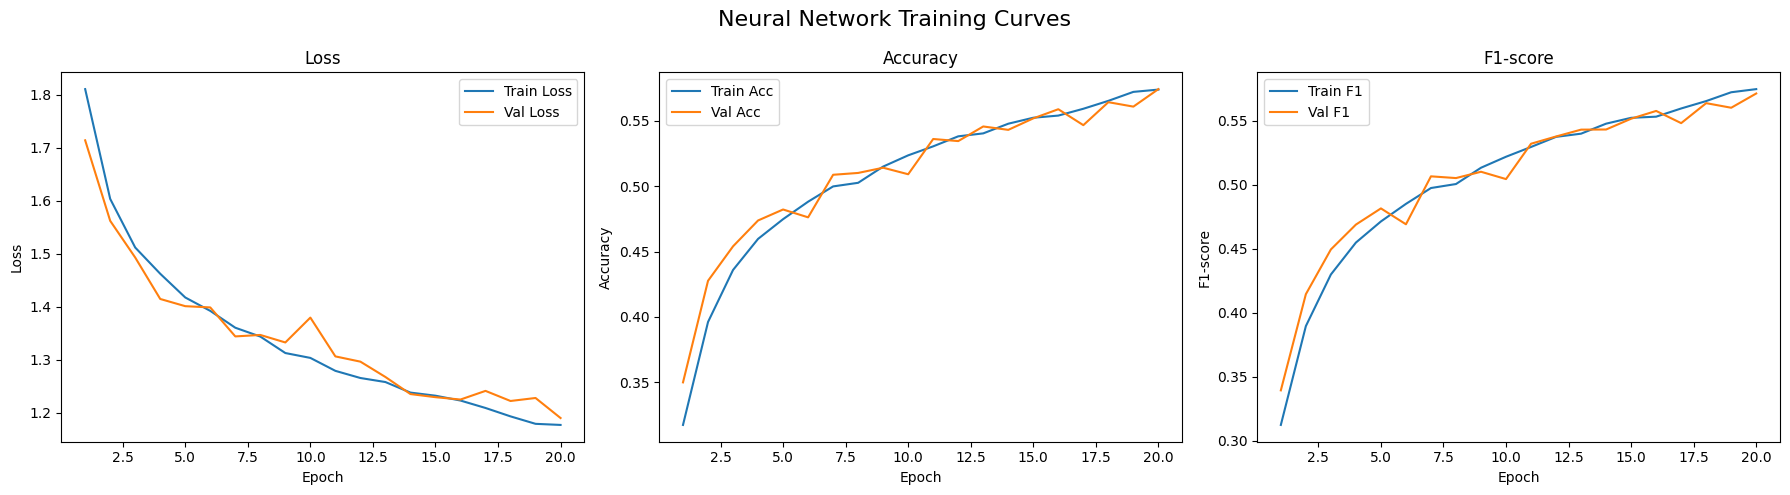

In [8]:
from utils.utils import plot_training_metrics
plot_training_metrics(metric_neural, 'Neural Network Training Curves')
